In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-06-03 16:50:10--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.005s  

2021-06-03 16:50:10 (14.1 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



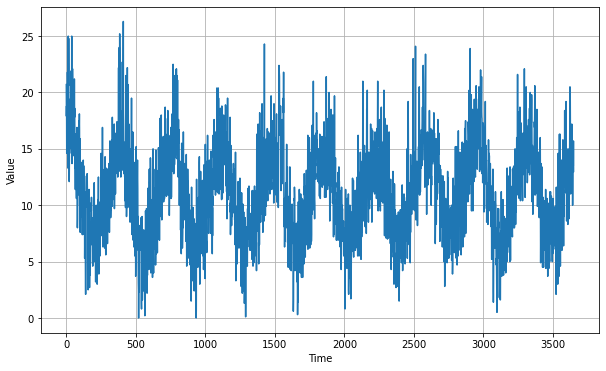

In [9]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  data = csv.reader(csvfile)
  next(data)
  for step, row in enumerate(data):
    time_step.append(step)
    temps.append(float(row[1]))

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [26]:
split_time = 2500
time_train = np.array(time[:split_time])
x_train = np.array(temps[:split_time])
time_valid = np.array(time[split_time:])
x_valid = np.array(temps[split_time:])

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [27]:
# def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
#     # YOUR CODE HERE
#     series = tf.expand_dims(series, axis=-1)
#     dataset = tf.data.Dataset.from_tensor_slices(series)
#     dataset = dataset.window(window_size+1, shift=1, drop_reminder=True)
#     dataste = dataset.flat_map(lambda x: x.batch(window_size+1))
#     dataset = dataset.shuffle(shuffle_buffer_size)
#     return dataset.batch(batch_size).prefetch(1).map(lambda x: (x[:-1], x[-1]))

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [28]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [32]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(32, 5, padding="causal", input_shape=[None, 1], activation="relu"),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
10/10 [==============================] - 19s 25ms/step - loss: 31.1571 - mae: 31.6550
Epoch 2/100
10/10 [==============================] - 0s 29ms/step - loss: 30.5778 - mae: 31.0756
Epoch 3/100
10/10 [==============================] - 0s 28ms/step - loss: 29.6825 - mae: 30.1801
Epoch 4/100
10/10 [==============================] - 0s 29ms/step - loss: 28.5613 - mae: 29.0586
Epoch 5/100
10/10 [==============================] - 0s 29ms/step - loss: 27.1974 - mae: 27.6945
Epoch 6/100
10/10 [==============================] - 0s 29ms/step - loss: 25.5017 - mae: 25.9986
Epoch 7/100
10/10 [==============================] - 0s 29ms/step - loss: 23.3464 - mae: 23.8429
Epoch 8/100
10/10 [==============================] - 0s 28ms/step - loss: 20.6147 - mae: 21.1108
Epoch 9/100
10/10 [==============================] - 0s 29ms/step - loss: 17.3142 - mae: 17.8091
Epoch 10/100
10/10 [==============================] - 0s 30ms/step - loss: 13.6448 - mae: 14.1371
Epoch 11/100
10/10 [========

(1e-08, 0.0001, 0.0, 60.0)

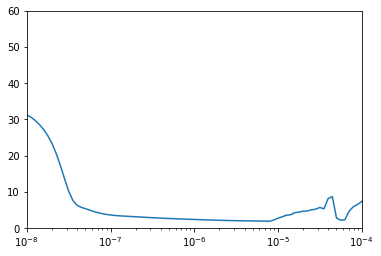

In [33]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-4, 0, 60])

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(32, 5, padding="causal", input_shape=[None, 1], activation="relu"),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
25/25 [==============================] - 3s 15ms/step - loss: 11.1526 - mae: 11.6424
Epoch 2/500
25/25 [==============================] - 1s 16ms/step - loss: 3.1129 - mae: 3.5835
Epoch 3/500
25/25 [==============================] - 1s 17ms/step - loss: 2.1982 - mae: 2.6568
Epoch 4/500
25/25 [==============================] - 1s 17ms/step - loss: 1.9699 - mae: 2.4240
Epoch 5/500
25/25 [==============================] - 1s 16ms/step - loss: 1.8769 - mae: 2.3285
Epoch 6/500
25/25 [==============================] - 1s 17ms/step - loss: 1.8259 - mae: 2.2767
Epoch 7/500
25/25 [==============================] - 1s 16ms/step - loss: 1.7926 - mae: 2.2440
Epoch 8/500
25/25 [==============================] - 1s 18ms/step - loss: 1.7689 - mae: 2.2202
Epoch 9/500
25/25 [==============================] - 1s 16ms/step - loss: 1.7883 - mae: 2.2389
Epoch 10/500
25/25 [==============================] - 1s 17ms/step - loss: 1.7477 - mae: 2.1982
Epoch 11/500
25/25 [===========================

In [35]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

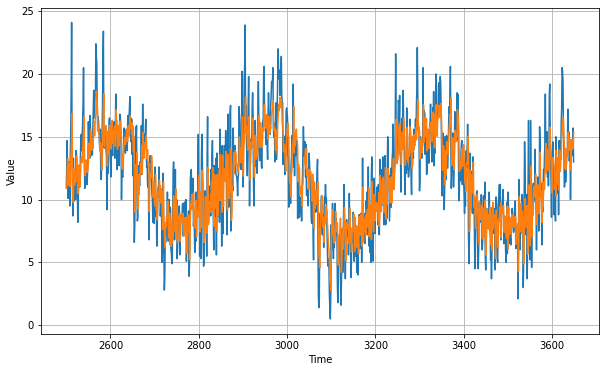

In [36]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [37]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8032267

In [38]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[10.899843 10.91898  12.323407 ... 14.030536 14.130664 15.349242]
